<a href="https://colab.research.google.com/github/Hassan-293/My-Project/blob/main/Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!ls '/content/drive/MyDrive/Histo Data'

lizard_images1	lizard_images2	lizard_labels  overlay	processed


In [62]:
!mkdir '/content/drive/MyDrive/Histo Data/processed'

In [5]:
from tensorflow import keras
import cv2


In [70]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

path ='/content/drive/MyDrive/Histo Data/lizard_images2/Lizard_Images2'
processed_path = '/content/drive/MyDrive/Histo Data/processed'

for filename in os.listdir(path):
    if filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(path, filename))

        # Resize the image
        image = cv2.resize(image, (224, 224))
        
        # Standardize the data by subtracting the mean and dividing by the standard deviation
        image = (image - np.mean(image)) / np.std(image)

        # Normalize the image
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

        
        # Save the processed image
        cv2.imwrite(f'/content/drive/MyDrive/Histo Data/processed/'+ filename.split('/')[-1], image)
           

In [8]:

def display_image(image_path):
    # Load the image
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image)
    plt.show()

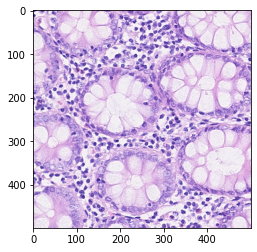

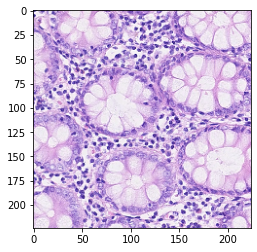

In [65]:
Unprocessed_Image='/content/drive/MyDrive/Histo Data/lizard_images1/Lizard_Images1/consep_11.png'
Processed_Image= '/content/drive/MyDrive/Histo Data/processed/consep_11.png'

display_image(Unprocessed_Image)

display_image(Processed_Image)



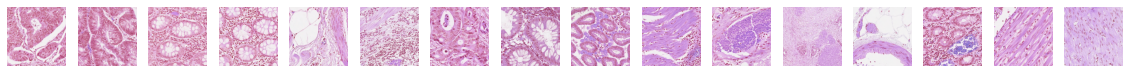

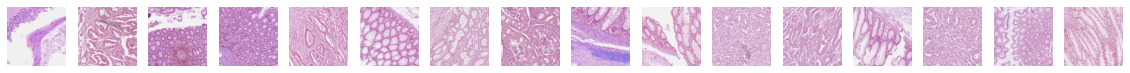

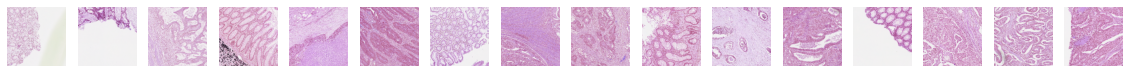

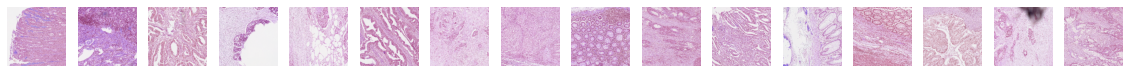

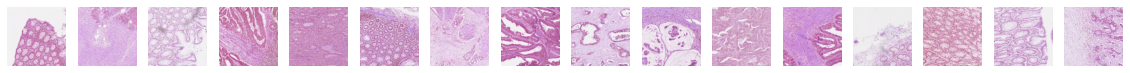

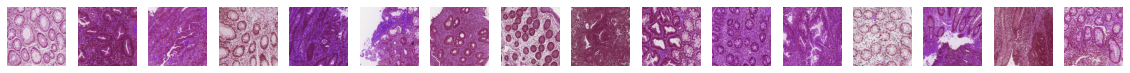

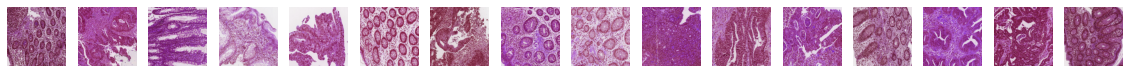

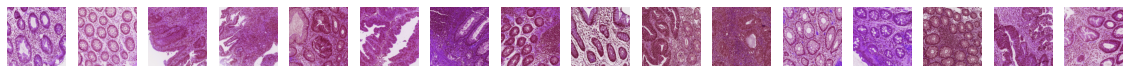

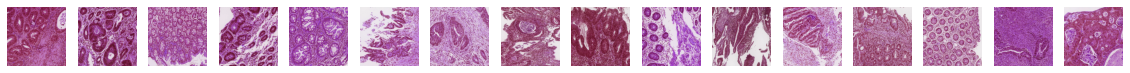

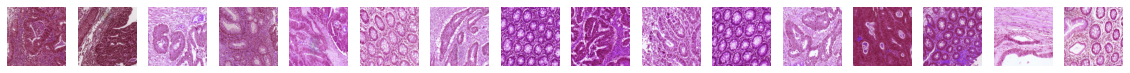

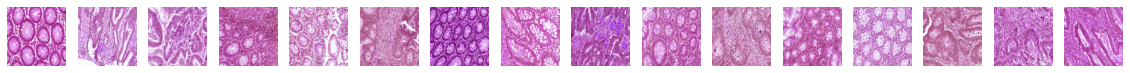

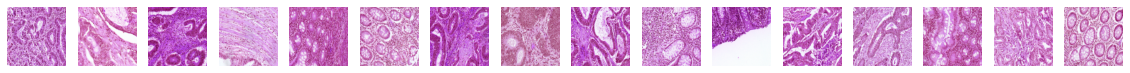

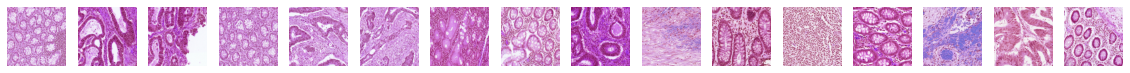

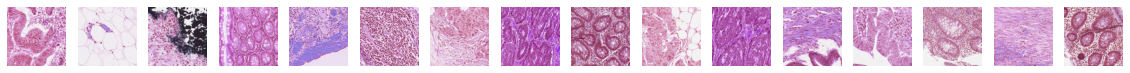

In [71]:
import glob

# Find all the images in the folder
image_files = glob.glob('/content/drive/MyDrive/Histo Data/processed/*.png')

# Load the images in a list
images = []
for file in image_files:
    img = cv2.imread(file)
    images.append(img)

# Divide the images into batches
batch_size = 16
num_batches = len(images) // batch_size
for i in range(num_batches):
    batch_images = images[i * batch_size:(i + 1) * batch_size]
    # Plot the images
    fig, axs = plt.subplots(1, len(batch_images), figsize=(20, 5))
    for i, img in enumerate(batch_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()
